<a href="https://colab.research.google.com/github/sokanaid/CourseProject2022BiologicalMath/blob/main/plateau_search_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Результаты поиска плато

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [19]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/sim_tables

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/sim_tables


## Чтение данных

In [20]:
def read_csv_file(directory_path, name):
  file_path = os.path.join(directory_path, name + ".csv")
  # print("read file ", file_path)
  return pd.read_csv(file_path)

In [21]:
def read_description(directory_path, file_name = "description.txt", parse_params = False):
  file_path = os.path.join(directory_path, file_name)
  # print("read description from file  ", file_path)
  with open(file_path, 'r') as file:
    if not parse_params:
      return file.read()
    result = {}
    for line in file:
      name, value = line.split('=')
      value = value.strip(' \t\n\r')
      if value == 'TRUE':
        value = True
      elif value == 'FALSE':
        value = False
      else:
        try:
          value = float(value)
        except:
          try:
            value = int(value)
          except:
            ...
      result[name] = value
    return result

In [22]:
def read_files(directory_path):
  data = {}
  # строковое описание параметров
  data["description_str"] = read_description(directory_path)
  # описание параметров в виде словаря
  data["params"] =  read_description(directory_path, parse_params = True)
  # численность популяции
  data["population"] = read_csv_file(directory_path, "population")
  data["population"].drop(data["population"].tail(1).index, inplace=True)
  data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  # результаты последовательных сглаживаний численности популяции
  name = "exp_pop10"
  data[name] = read_csv_file(directory_path, name)
  data[name].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  return data

In [23]:
# читаем все результаты симуляций из папок
def read_all_simulations(directories_paths):
  data = []
  for directory_path in directories_paths:
    for simulation_diractory_name in os.listdir(directory_path):
      simulation_diractory_path = os.path.join(directory_path, simulation_diractory_name)
      if os.path.isdir(simulation_diractory_path):
        data.append(read_files(simulation_diractory_path))
  return data

## Построение графиков

In [24]:
def print_pair(data1, data2, x="time", color = 'b'):
  fig = plt.figure(figsize=(20, 8), dpi=80)
  plt.axis('off')
  plt.title("Simulation" )
  fig.tight_layout(pad=6.0,  h_pad=3, w_pad=3)
  fig.patch.set_visible(False)
  axes = fig.subplots(nrows=1, ncols=2)
  for i, data_ in enumerate([data1, data2]):
    axes[i].plot(data_["population"][x], data_["population"]['pop'],color, label="auto_stop_at_plateau=" +str(data_["params"]["auto_stop_at_plateau"]))
    axes[i].legend(loc="lower right")
    axes[i].set_xlabel(x)
    axes[i].set_ylabel('pop')

## Результаты симуляций

In [25]:
directories = ["/content/drive/MyDrive/sim_tables/plateau_threshold_check20"]
data = read_all_simulations(directories)

In [26]:
# ищем симуляции на которых не вышли на плато
count = 0
no_plateau_finding = 0
for sim_data in data:
  if sim_data["params"]["auto_stop_at_plateau"] and not sim_data["params"]["found_plateau"]:
    print(sim_data["description_str"])
  elif sim_data["params"]["auto_stop_at_plateau"]:
    count+=1
  else:
    no_plateau_finding+=1

print("successful: ", count)
print("plateau not found: ", len(data) - count - no_plateau_finding)
print("total: ", len(data) - no_plateau_finding)
print("total simulations: ", len(data))

successful:  96
plateau not found:  0
total:  96
total simulations:  192


In [27]:
# поиск симуляции с теми же параметрами, но без остановки на плато
def find_pair_sim(sim_data, data):
  if not sim_data["params"]["auto_stop_at_plateau"]:
    print(sim_data)
    print("auto_stop_at_plateau = False")
    return
  params = sim_data["params"].copy()
  params.pop("realtime_limit_reached", None)
  params.pop("plateau_threshold", None)
  params["found_plateau"] = False
  params["auto_stop_at_plateau"] = False
  
  pair_sim = None
  for other_sim_data in data:
    is_pair_sim = True
    for param in params:
      if other_sim_data["params"][param]!=params[param]:
        is_pair_sim = False
        break
    if is_pair_sim:
      pair_sim = other_sim_data
      break
  if pair_sim is None:
    print("pair not found params:", sim_data["str_description"])
  return pair_sim

In [28]:
# найдем симуляции, для которых график без остановки на плато продолжил падать/ расти
big_diff_count =0 
print(len(data))
dif_arr = []
for sim_data in data:
  if not sim_data["params"]["auto_stop_at_plateau"]:
    continue
  # ищем парную симуляцию без остановки на плато
  pair_sim = find_pair_sim(sim_data, data)
  # рассмотрим отношение средних численностей популяций последних 100 эпох парных симуляций
  dif = sim_data["population"].tail(100)['pop'].mean()/pair_sim["population"].tail(100)['pop'].mean()
  # Проверим результаты вручную,если были выбрано недостаточное количество эпох для парной симуляции
  # или данные парная симуляция начала расти/убывать после предполагаемого выхода на плато
  if len(pair_sim["population"])==len(sim_data["population"]):
    print("less epochs then need. params:", sim_data["description_str"])
    print_pair(sim_data, pair_sim)
  if dif > 1.05 or dif < 0.95:
    print("big diff params:", sim_data["description_str"])
    print_pair(sim_data, pair_sim, color = 'r')
    count+=1
  dif_arr.append(dif)
print("count of simulations with ponesial wrong plateau :", big_diff_count)
print("dif description:")
pd.DataFrame(dif_arr).describe()


192
count of simulations with ponesial wrong plateau : 0
dif description:


,0
count,96.000000
mean,1.000255
std,0.005362
min,0.987437
25%,0.996705
50%,0.999045
75%,1.003361
max,1.014789


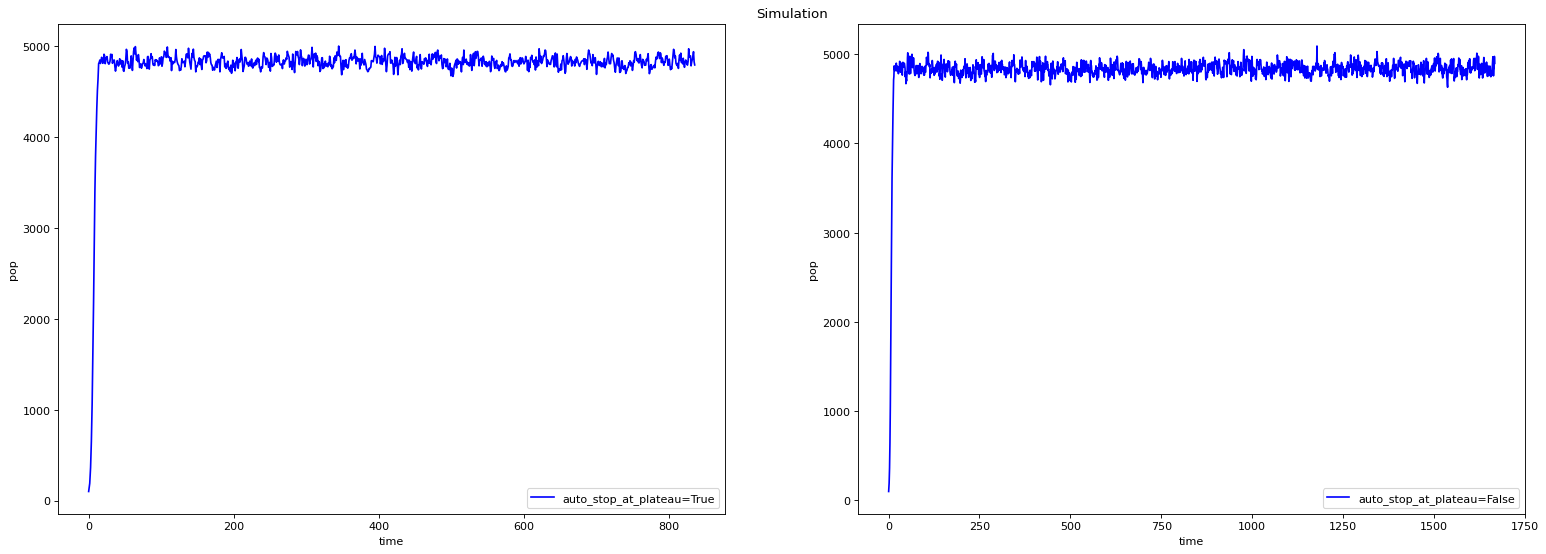

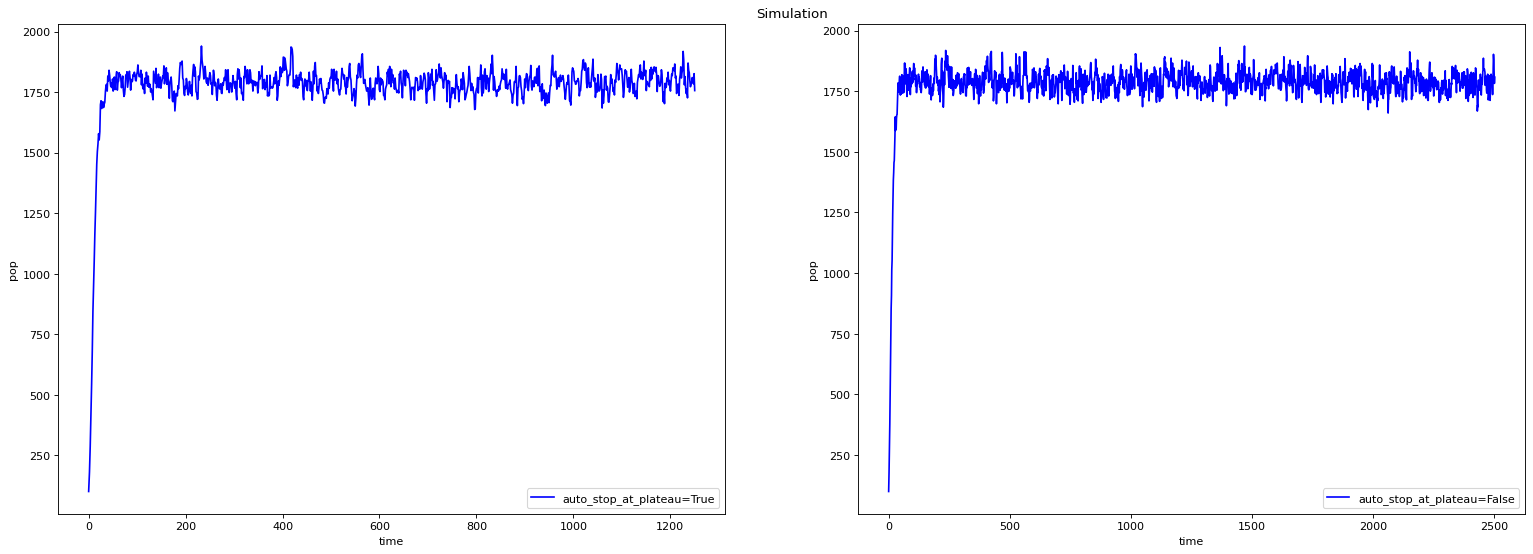

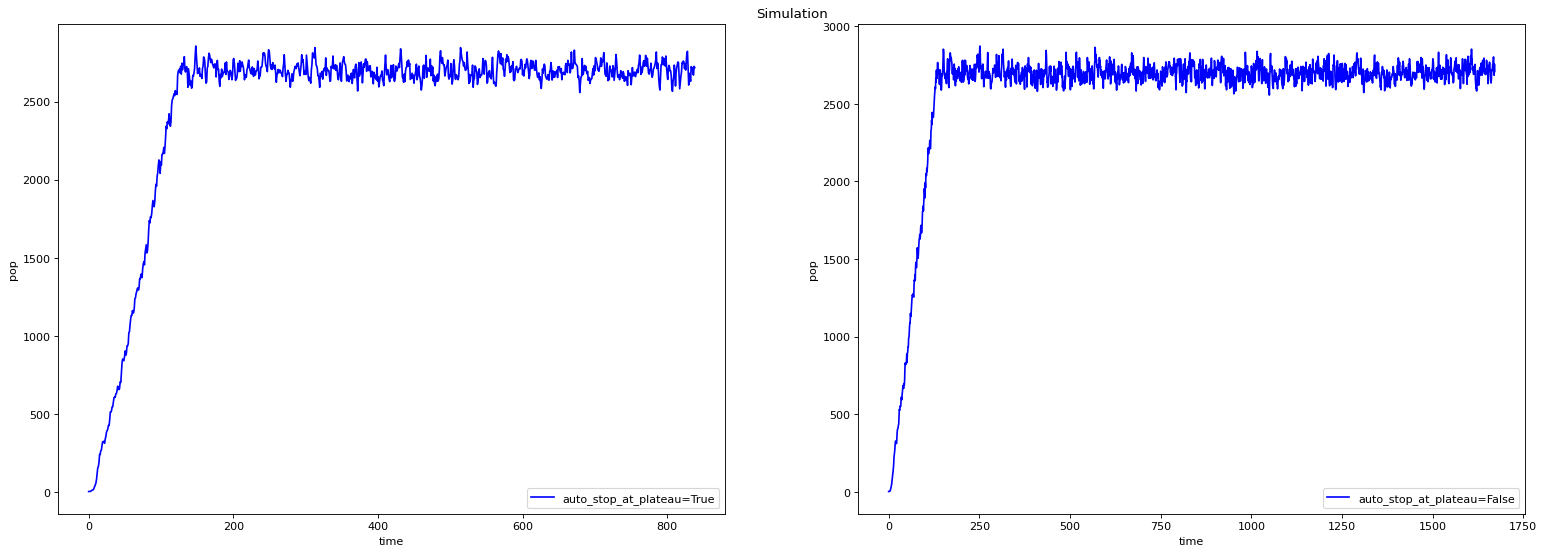

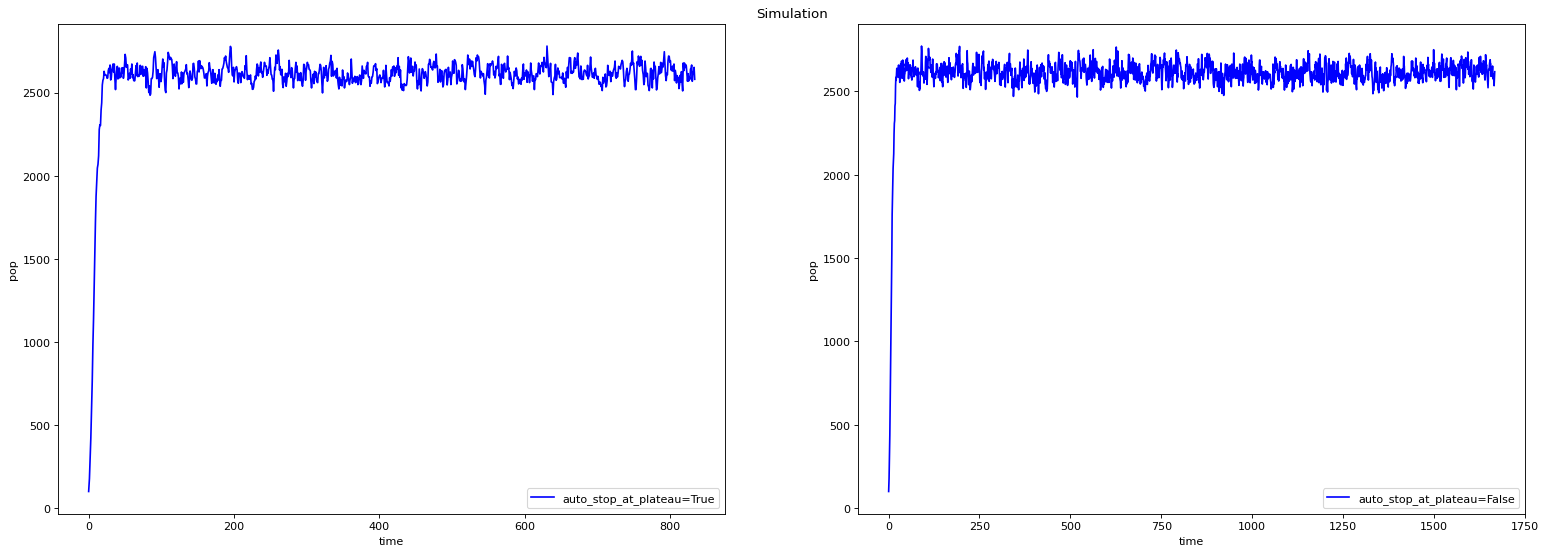

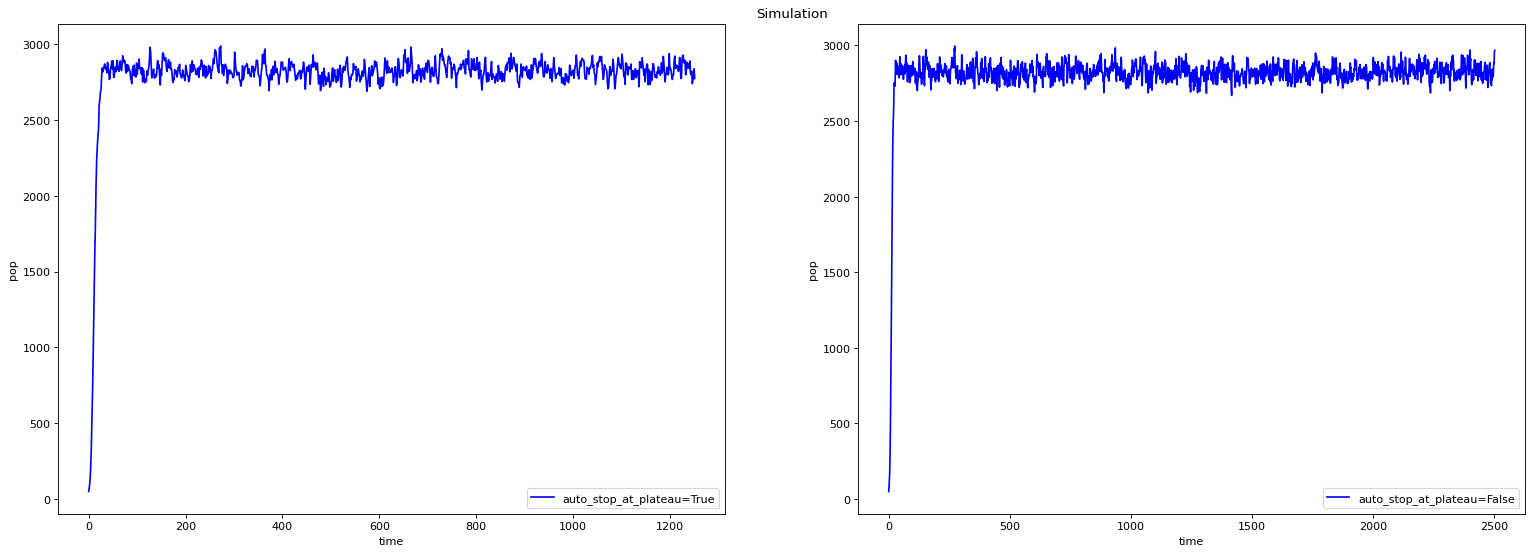

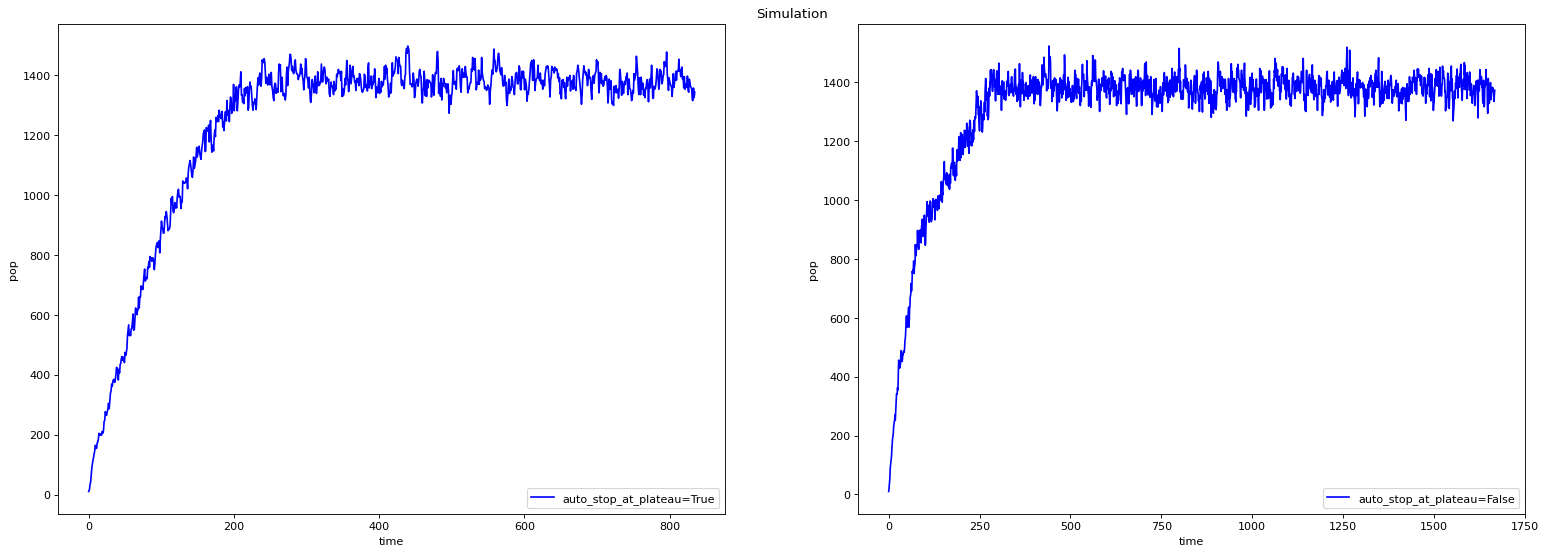

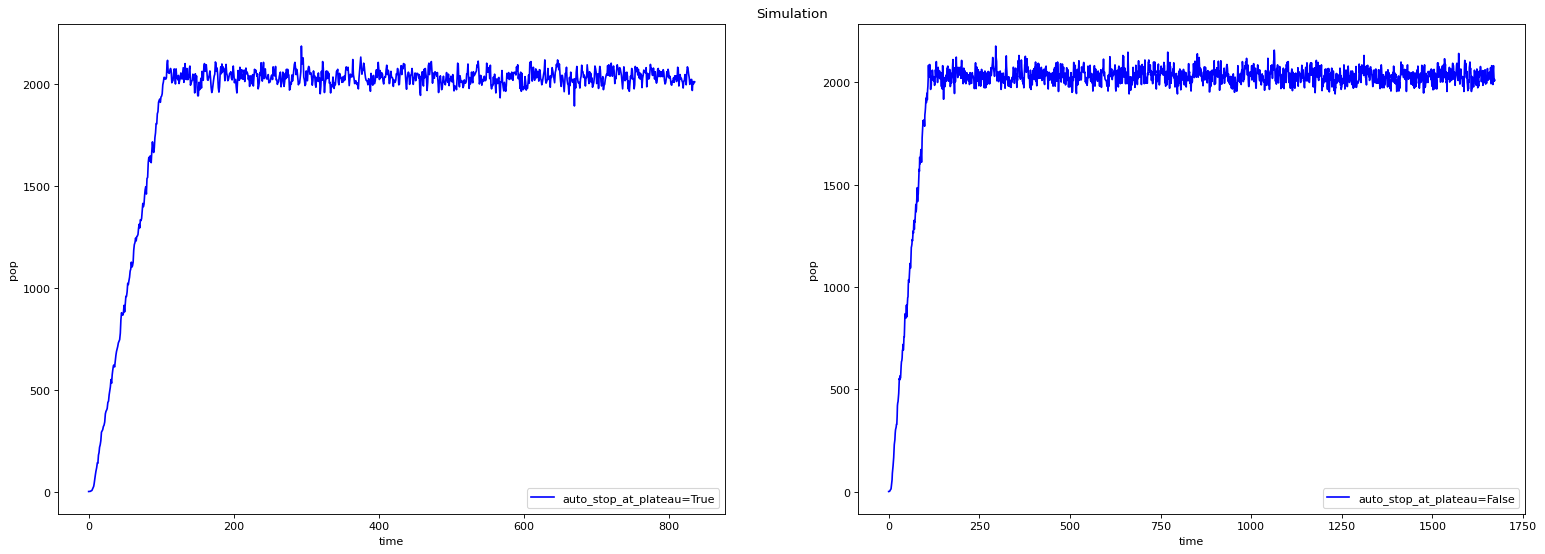

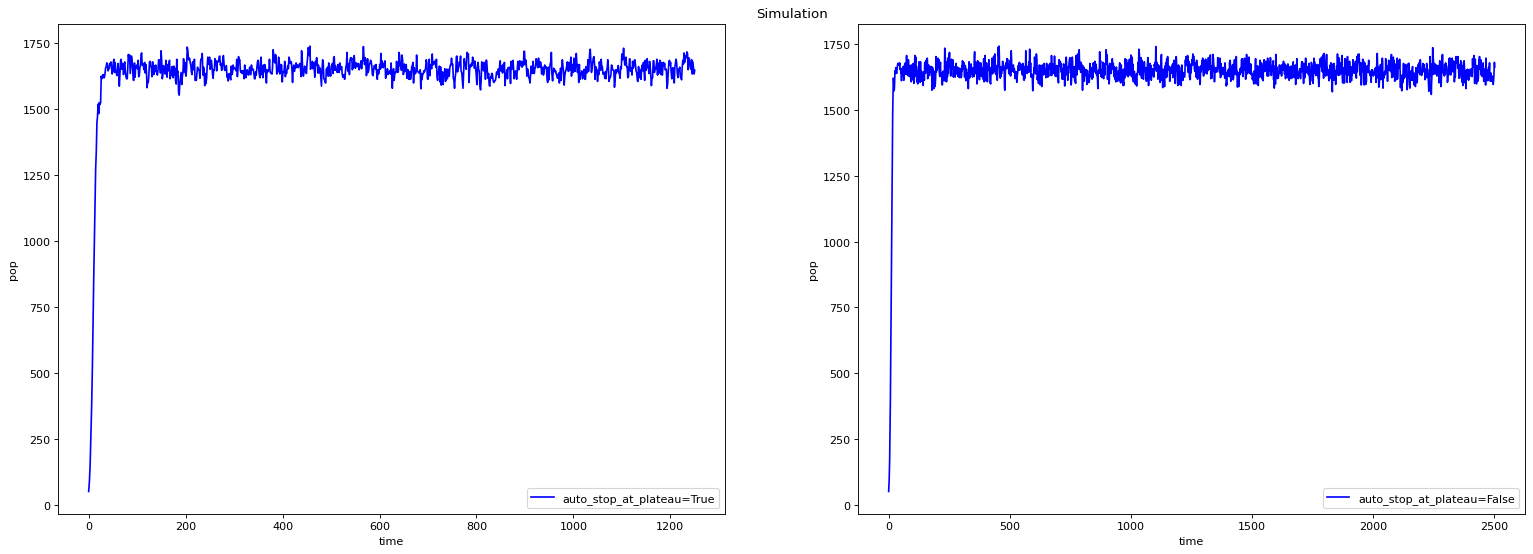

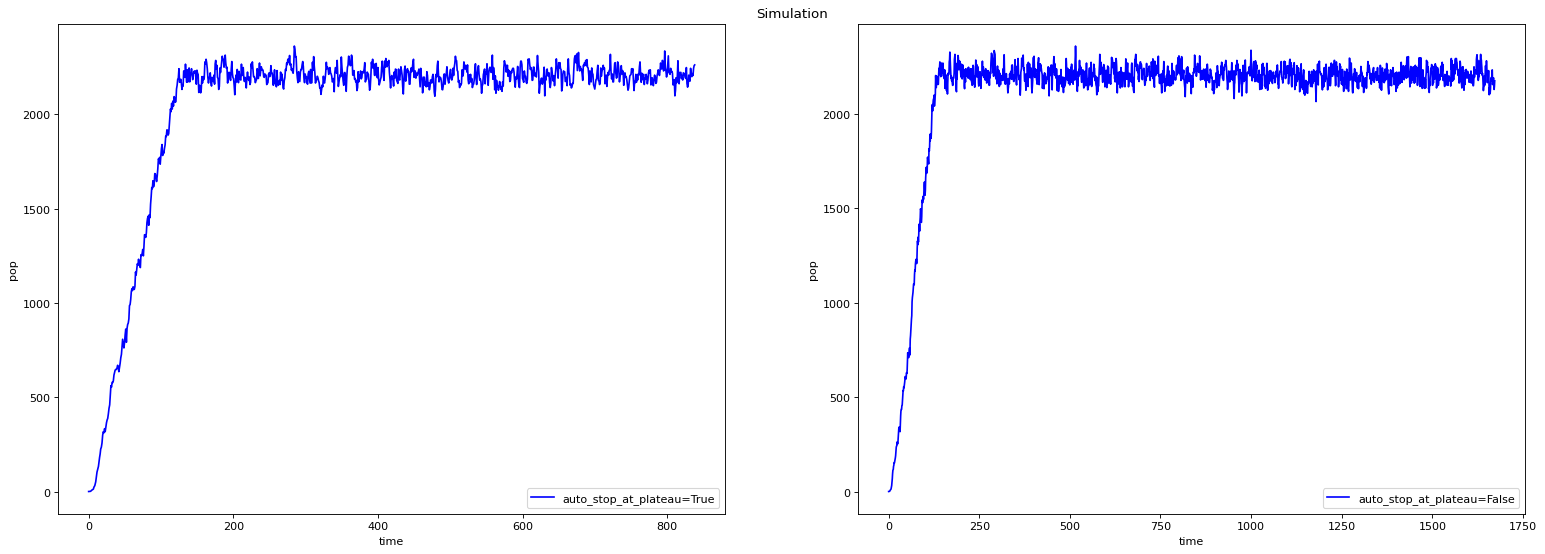

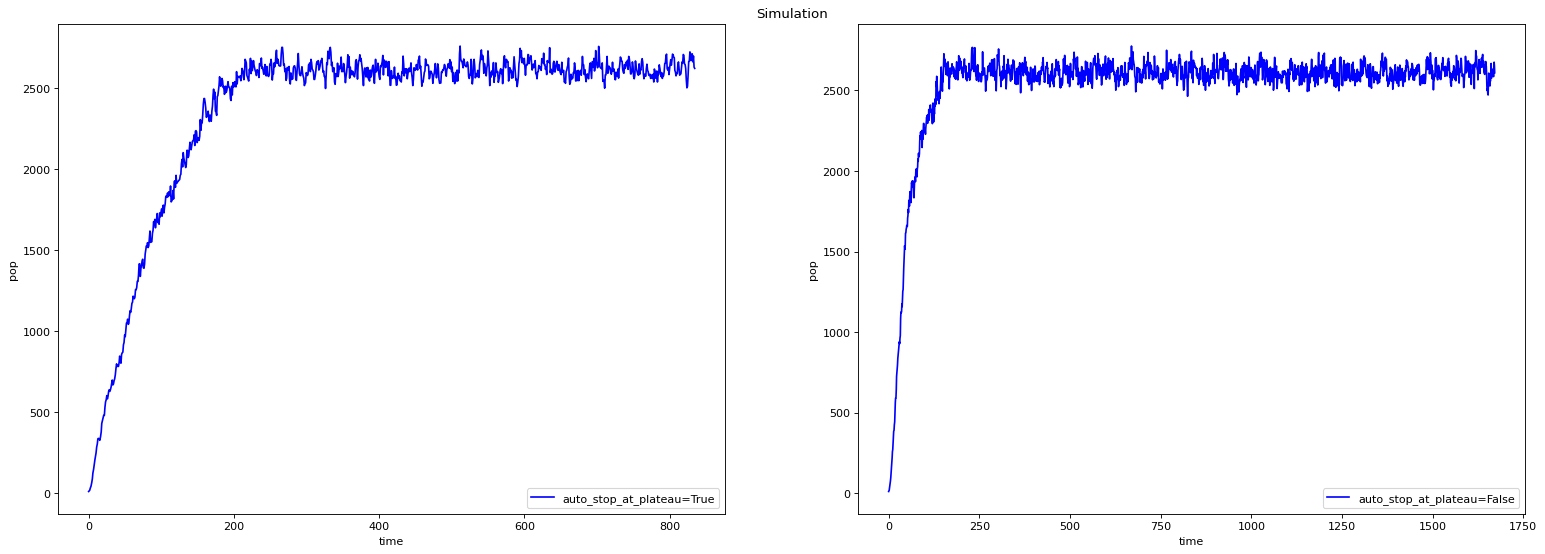

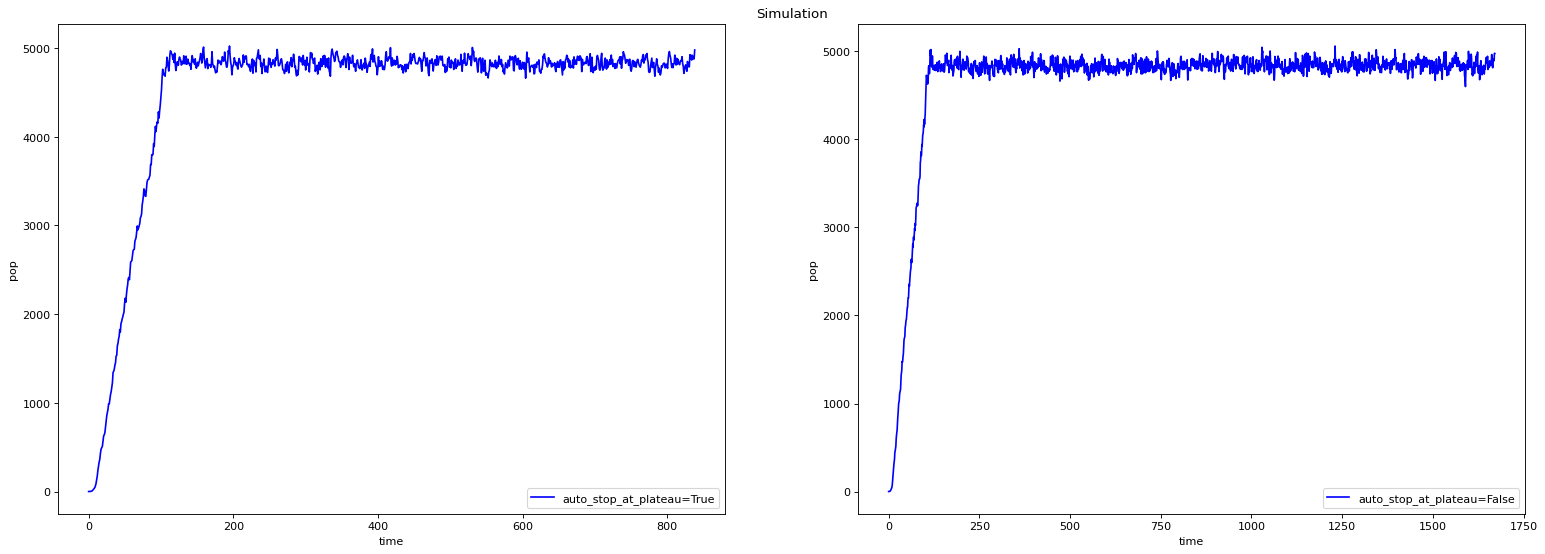

In [29]:
i = 0
# демонстрация примеров пар симуляций
for sim_data in data:
  if not sim_data["params"]["auto_stop_at_plateau"]:
    continue
  # ищем парную симуляцию без остановки на плато
  pair_sim = find_pair_sim(sim_data, data)
  print_pair(sim_data, pair_sim)
  i+=1
  if i > 10:
    break

## Сетка параметров симуляций

In [30]:
data[0]["params"]

{'dd': 0.2,
 'death_r': 0.4,
 'epochs_count': 2000.0,
 'plateau_threshold': 20.0,
 'area_length_x': 100.0,
 'initial_pop': 1.0,
 'auto_stop_at_plateau': False,
 'b': 0.4,
 'sd_b': 0.7,
 'sd_d': 0.2,
 'found_plateau': False,
 'realtime_limit_reached': False}

In [31]:
def add_sim(data_frame, sim):
  params = sim["params"]
  mean_pop = sim["population"].tail(100)['pop'].mean()
  d =  params['d'] if 'd' in params else 0
  new_row = pd.Series({'b': params['b'],'d':d, 'death_r': params['death_r'], 'dd':params['dd'],'sd_b':params['sd_b'], 'sd_d':params['sd_d'],
                    'area_length_x':params['area_length_x'], 'initial_pop':params['initial_pop'], 'plateau_pop': mean_pop})
  data_frame = pd.concat([data_frame, new_row.to_frame().T], ignore_index=True)
  return data_frame

In [32]:
sim_frame = pd.DataFrame(columns=['b', 'd','death_r', 'dd','sd_b', 'sd_d', 'area_length_x', 'initial_pop', 'plateau_pop'])
for sim in data:
  if not sim["params"]["auto_stop_at_plateau"]:
    continue
  sim_frame = add_sim(sim_frame, sim)
  

In [33]:
sim_frame = sim_frame.sort_values(by=['b', 'd','death_r', 'dd','sd_b', 'sd_d', 'area_length_x', 'initial_pop']).reset_index(drop=True)

In [34]:
pd.set_option('display.max_rows', None)
# все параметры симуляций и средние значения численности популяции на плато
sim_frame

,b,d,death_r,dd,sd_b,sd_d,area_length_x,initial_pop,plateau_pop
0,0.4,0.0,0.4,0.2,0.2,0.7,100.0,1.0,2721.56
1,0.4,0.0,0.4,0.2,0.2,0.7,100.0,10.0,2724.04
2,0.4,0.0,0.4,0.2,0.2,0.7,100.0,50.0,2722.88
3,0.4,0.0,0.4,0.2,0.2,0.7,100.0,100.0,2726.22
4,0.4,0.0,0.4,0.2,0.6,0.6,100.0,1.0,2823.74
5,0.4,0.0,0.4,0.2,0.6,0.6,100.0,10.0,2828.94
6,0.4,0.0,0.4,0.2,0.6,0.6,100.0,50.0,2826.74
7,0.4,0.0,0.4,0.2,0.6,0.6,100.0,100.0,2823.88
8,0.4,0.0,0.4,0.2,0.7,0.2,100.0,1.0,3629.30
9,0.4,0.0,0.4,0.2,0.7,0.2,100.0,10.0,3624.62
